In [5]:
import pandas as pd
import numpy as np
from numpy import *
import operator
from os import listdir
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')  # 忽略警告（看到一堆警告比较恶心）

In [6]:
# target 与各个属性的关系
# 1、数据获取
# 2、数据处理(show)
# 3、模型搭建
# 4、分类误差
color = sns.color_palette()  # sns调色板
sns.set_style('dark')  # 设置主题模式
# 1、数据获取   查看数据
df = pd.read_csv(r'E:\积累\KNN\MammaryCancerData.csv')

In [7]:
print(df.info())  # 无缺失值，数据很完整，故不做预处理

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
radius_mean         569 non-null float64
texture_mean        569 non-null float64
perimeter_mean      569 non-null float64
area_mean           569 non-null float64
smoothness_mean     569 non-null float64
compactness_mean    569 non-null float64
concavity_mean      569 non-null float64
concave_mean        569 non-null float64
symmetry_mean       569 non-null float64
fractal_mean        569 non-null float64
radius_sd           569 non-null float64
texture_sd          569 non-null float64
perimeter_sd        569 non-null float64
area_sd             569 non-null float64
smoothness_sd       569 non-null float64
compactness_sd      569 non-null float64
concavity_sd        569 non-null float64
concave_sd          569 non-null float64
symmetry_sd         569 non-null float64
fractal_sd          569 non-null float64
radius_max          569 non-null float64
texture_max         569 non-null f

In [8]:
print(df.describe())

       radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave_mean  \
count       569.000000        569.000000      569.000000    569.000000   
mean          0.096360          0.104341        0.088799      0.048919   
std           0.014064          0.052813        0.079720      0.038803   
min           0.052630          0.019380        0.000000      0.000000   
25%           0.086370          0.064920    

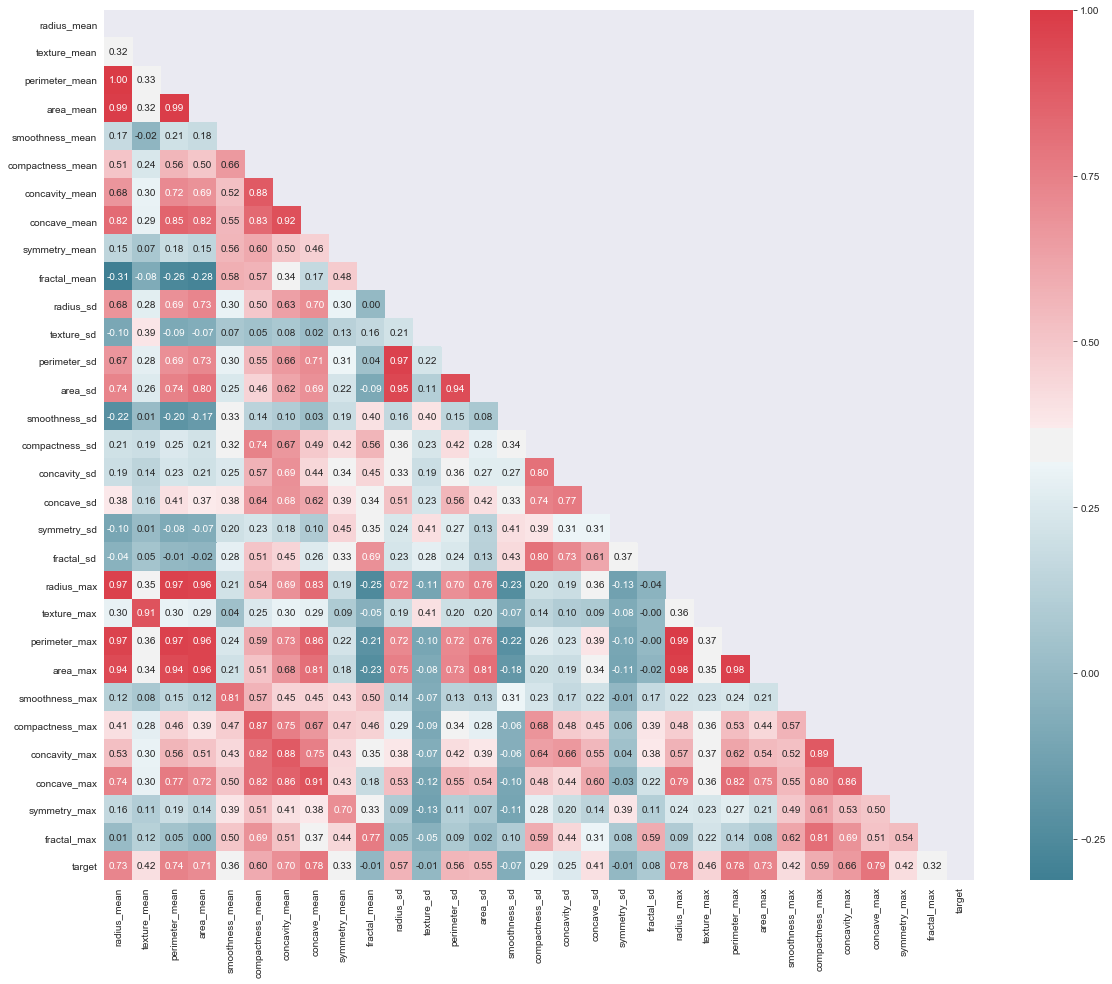

In [9]:
# 2、数据处理（show）
# 找出相关程度
plt.figure(figsize=(20, 16))  # 指定绘图对象宽度和高度
colnm = df.columns.tolist()[:31]  # 列表头
mcorr = df[colnm].corr()  # 相关系数矩阵，即给出了任意两个变量之间的相关系数
mask = np.zeros_like(mcorr, dtype=np.bool)  # 构造与mcorr同维数矩阵 为bool型
mask[np.triu_indices_from(mask)] = True  # 角分线右侧为True
cmap = sns.diverging_palette(220, 10, as_cmap=True)  # 返回matplotlib colormap对象
g = sns.heatmap(mcorr, mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')  # 热力图（看两两相似度）
plt.show()

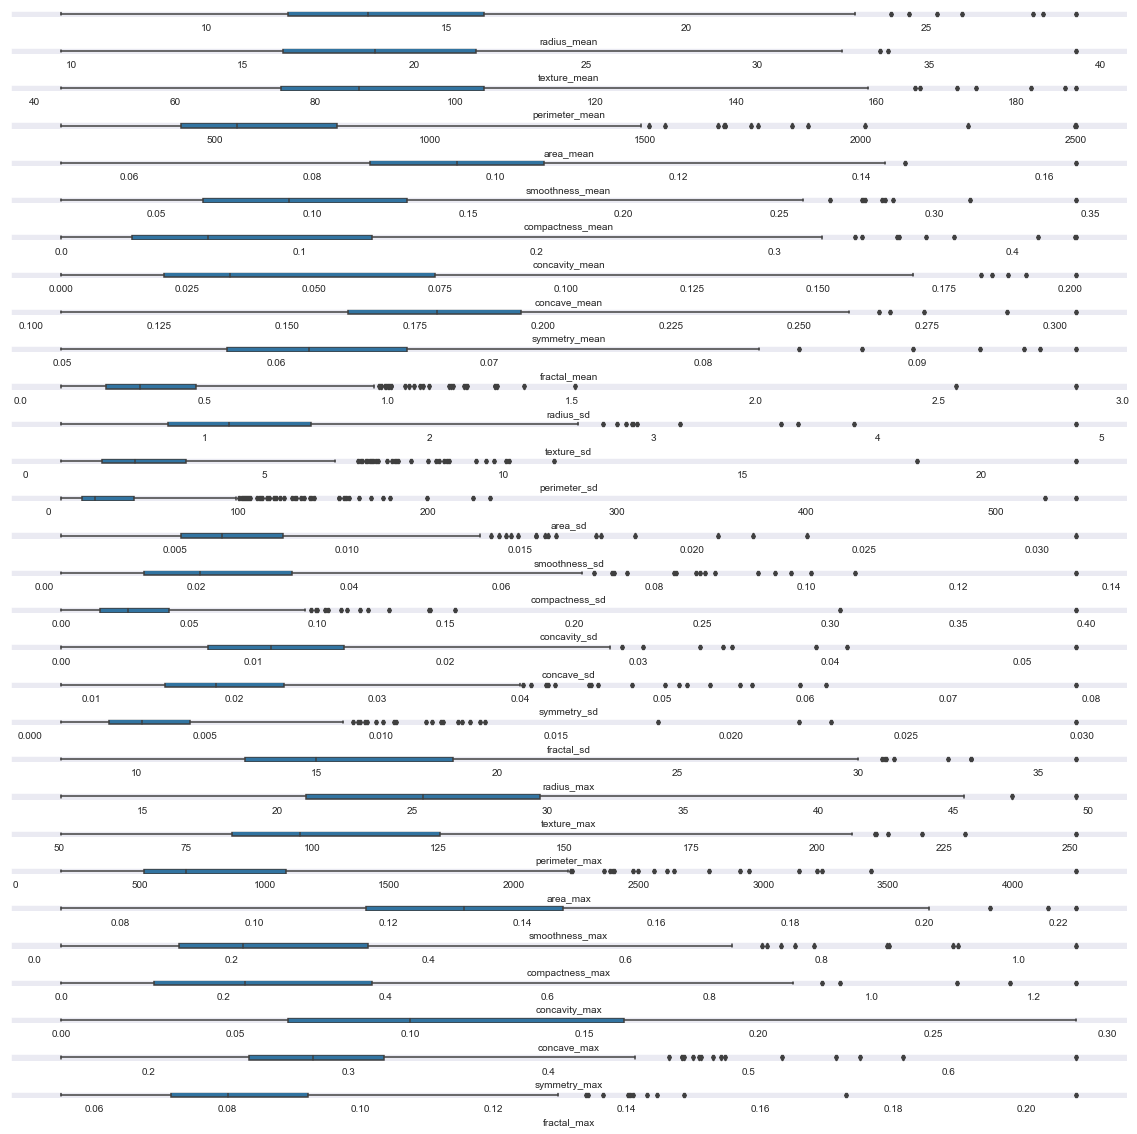

In [10]:
# 画箱式图
subsets = ['radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean',
           'concavity_mean','concave_mean','symmetry_mean','fractal_mean','radius_sd','texture_sd','perimeter_sd',
           'area_sd','smoothness_sd','compactness_sd','concavity_sd','concave_sd','symmetry_sd','fractal_sd','radius_max',
           'texture_max','perimeter_max','area_max','smoothness_max','compactness_max','concavity_max','concave_max','symmetry_max',
           'fractal_max']
# 箱型图，获取数据大致分布情况，查看离群点信息
fig, axes = plt.subplots(len(subsets), 1, figsize=(20, 20))
plt.subplots_adjust(hspace=5)
for i, subset in enumerate(subsets):
    sns.boxplot(df[subset], ax=axes[i], whis=2, orient='h')
plt.show()

In [11]:
# 3、模型搭建（KNN）
# k-近邻算法
# 对未知类别属性的数据集中的每个点依次执行以下操作：
# (1) 计算已知类别数据集中的点与当前点之间的距离；
# (2) 按照距离递增次序排序；
# (3) 选取与当前点距离最小的k个点；
# (4) 确定前k个点所在类别的出现频率；
# (5) 返回前k个点出现频率最高的类别作为当前点的预测
def classify0(inx, dataset, labels, k):# 用于分类的输入向量是inX，输入的训练样本集为dataSet，标签向量为labels，最后的参数k表示用于选择最近邻居的数目
    dataSetSize = dataset.shape[0]  # 矩阵行数就是数据数量 shape[0]-行数 shape[1]-列数
    diffMat = tile(inx, (dataSetSize, 1)) - dataset # tile(A,reps)把数组沿着各个方向复制 m行1列
    sqDiffMat = diffMat ** 2
    sqDistance = sqDiffMat.sum(axis=1) # axis=0按列相加 =1按行相加
    distance = sqDistance ** 0.5  # 欧式距离公式计算距离
    sortedDistIndicies = distance.argsort()  # argsort()函数是将distance中的元素从小到大排列，提取其对应的index(索引)，然后输出到sortedDistIndicies
    classCount = {} # 建立一个空集合
    for i in range(k):
        voteIlabel = labels[sortedDistIndicies[i]]  # 提取排序好了的标签
        classCount[voteIlabel] = classCount.get(voteIlabel, 0) + 1 # Python 字典(Dictionary) get() 函数返回指定键的值，如果值不在字典中返回默认值（0）。
        # 按照第二个元素的次序对元组进行排序 此处的排序为逆序，即按照从最大到最小次序排序，最后返回发生频率最高的元素标签
        sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
        return sortedClassCount[0][0]

In [12]:
# 将文本记录转换为NumPy的解析程序  输出为训练样本矩阵和类标签向量
def file2matrix(filename):
    f = open(filename)
    arrayOLines = f.readlines()
    numberOfLines = len(arrayOLines) # 得到文件行数
    returnMat = zeros((numberOfLines, 30)) # 创建一个numberOfLines行  30列的0矩阵 根据数据特征值个数确定
    classLabelVector = []
    index = 0
    for line in arrayOLines:
        line = line.strip()  # 函数line.strip()截取掉所有的回车字符
        listFromLine = line.split('\t')  # 后使用tab字符\t将上一步得到的整行数据分割成一个元素列表。
        returnMat[index, :] = listFromLine[0:30]  # 选取每行前3个元素，将它们存储到特征矩阵中
        classLabelVector.append(int(listFromLine[-1]))  # 将列表的最后一列存储到向量classLabelVector中
        index += 1
    return returnMat, classLabelVector

In [13]:
# 归一化特征值  该函数可以自动将数字特征值转化为0到1的区间 newValue = (oldValue - min)/(max - min)
def autoNorm(dataSet):
    minVals = dataSet.min(0) # 每列的最小值
    maxVals = dataSet.max(0) # 每列的最大值
    ranges = maxVals - minVals  #  每列的极差
    normDataSet = zeros(shape(dataSet))  # 建立0矩阵
    m = dataSet.shape[0]
    normDataSet = dataSet - tile(minVals, (m, 1))
    normDataset = normDataSet / tile(ranges, (m, 1))
    return normDataSet, ranges, minVals


In [14]:
# 分类器代码
def datingClassTest():
    hoRatio = 0.10 # 选取10%测试
    datingDataMat, datingLabels = file2matrix(r'E:\积累\KNN\MammaryCancerData.txt')
    norMat, ranges, minVals = autoNorm(datingDataMat)
    m = norMat.shape[0]
    numTestVecs = int(m * hoRatio)  # 10%的测试数据数量
    errorCount = 0.0
    for i in range(numTestVecs):
        classifierResult = classify0(norMat[i, :], norMat[numTestVecs:m,:], datingLabels[numTestVecs:m], 3)
        print("the classifier came back with:%d, the real answer is: %d" % (classifierResult, datingLabels[i]))
        if (classifierResult != datingLabels[i]):
            errorCount += 1.0
    print("the totle error rate is: %f" % (errorCount / float(numTestVecs)))  # 错误率

In [15]:
datingClassTest()

the classifier came back with:1, the real answer is: 1
the classifier came back with:1, the real answer is: 1
the classifier came back with:1, the real answer is: 1
the classifier came back with:0, the real answer is: 1
the classifier came back with:1, the real answer is: 1
the classifier came back with:1, the real answer is: 1
the classifier came back with:1, the real answer is: 1
the classifier came back with:1, the real answer is: 1
the classifier came back with:0, the real answer is: 1
the classifier came back with:1, the real answer is: 1
the classifier came back with:1, the real answer is: 1
the classifier came back with:1, the real answer is: 1
the classifier came back with:1, the real answer is: 1
the classifier came back with:0, the real answer is: 1
the classifier came back with:0, the real answer is: 1
the classifier came back with:1, the real answer is: 1
the classifier came back with:1, the real answer is: 1
the classifier came back with:1, the real answer is: 1
the classi